## Training word embeddings on Harry Potter books corpus

In [1]:
# bridging Python versions
from __future__ import absolute_import, division, print_function

In [2]:
# for openning and processing the data files
import codecs # encoding the corpus into utf-8
import glob  # Unix style pathname pattern
import logging
import multiprocessing
from joblib import Parallel, delayed  # for parallel computation
import os
import re
import time
from collections import OrderedDict, deque

In [3]:
import nltk  # for text cleaning
from gensim.models.phrases import Phraser, Phrases
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# for plotting and analyzing the results

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.manifold import TSNE # for dimensionality reduction to plot similar words

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### setting up the logging

In [6]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### Downloading the tokenizer model from nltk

In [7]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/ammar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Loading Harry Potter books

In [8]:
book_names = sorted(glob.glob("data/*.txt"))
book_names

['data/hp1.txt',
 'data/hp2.txt',
 'data/hp3.txt',
 'data/hp4.txt',
 'data/hp5.txt',
 'data/hp6.txt',
 'data/hp7.txt']

#### create one string of all the books

In [9]:
raw_corpus = u""  # will use utf-8
for filename in book_names:
    print("Reading {}...".format(filename.split("/")[1]))
    with codecs.open(filename,"r","utf-8") as book:
        raw_corpus += book.read() 
    print("Corpus now is {} characters and {} words long".format(len(raw_corpus), len(raw_corpus.split())))
    print("~"*30)

Reading hp1.txt...
Corpus now is 442745 characters and 78449 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp2.txt...
Corpus now is 932472 characters and 165674 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp3.txt...
Corpus now is 1543433 characters and 271749 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp4.txt...
Corpus now is 2650206 characters and 467521 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp5.txt...
Corpus now is 4131978 characters and 726862 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp6.txt...
Corpus now is 5117585 characters and 900224 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp7.txt...
Corpus now is 6250142 characters and 1100343 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### loading the tokenizer

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(raw_corpus.lower())

In [12]:
raw_sentences[:2]

["harry potter and the sorcerer's stone \n\nchapter one \n\nthe boy who lived \n\nmr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much.",
 "they were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense."]

In [13]:
def sentence_to_wordlist(raw:str):
    return re.sub("[^a-zA-Z]"," ", raw).split()

In [14]:
# converting sentences to wordlists, utilizing all the cpu cores
tokenized_sentences = Parallel(n_jobs=-1)(
                delayed(sentence_to_wordlist)(
                    raw_sentence) for raw_sentence in raw_sentences)

In [15]:
print(raw_sentences[10])
print(tokenized_sentences[10])

the dursleys knew that the potters had a small son, too, but they had never even seen him.
['the', 'dursleys', 'knew', 'that', 'the', 'potters', 'had', 'a', 'small', 'son', 'too', 'but', 'they', 'had', 'never', 'even', 'seen', 'him']


# Word2Phrase (bigrams)
## e.g. new_york

In [16]:
phrases = Phrases(tokenized_sentences)

2018-07-19 20:30:51,437 : INFO : collecting all words and their counts
2018-07-19 20:30:51,438 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-07-19 20:30:51,673 : INFO : PROGRESS: at sentence #10000, processed 128427 words and 62790 word types
2018-07-19 20:30:51,915 : INFO : PROGRESS: at sentence #20000, processed 257842 words and 105427 word types
2018-07-19 20:30:52,096 : INFO : PROGRESS: at sentence #30000, processed 377963 words and 139813 word types
2018-07-19 20:30:52,266 : INFO : PROGRESS: at sentence #40000, processed 487238 words and 167134 word types
2018-07-19 20:30:52,516 : INFO : PROGRESS: at sentence #50000, processed 640144 words and 205287 word types
2018-07-19 20:30:52,748 : INFO : PROGRESS: at sentence #60000, processed 793495 words and 240556 word types
2018-07-19 20:30:52,954 : INFO : PROGRESS: at sentence #70000, processed 925964 words and 270064 word types
2018-07-19 20:30:53,148 : INFO : PROGRESS: at sentence #80000, processed 1055555

In [17]:
bigram = Phraser(phrases)

2018-07-19 20:30:53,251 : INFO : source_vocab length 310226
2018-07-19 20:30:56,208 : INFO : Phraser built with 2238 2238 phrasegrams


In [18]:
sentences = list(bigram[tokenized_sentences])

In [19]:
tokens_count = sum([len(sen) for sen in sentences])
no_bigram_count = sum([len(s) for s in tokenized_sentences])
print("""This corpus has:\n
                {0:,} tokens with bigrams\n
                {1:,} tokens without bigrams\n
                {2:} of the tokens have been included in phrases""".format(
    tokens_count,no_bigram_count, 1-tokens_count/no_bigram_count))

This corpus has:

                1,048,809 tokens with bigrams

                1,120,879 tokens without bigrams

                0.06429775203211052 of the tokens have been included in phrases


In [20]:
word2int = OrderedDict()
for sent in sentences:
    for w in sent:
        word2int.setdefault(w, len(word2int))
int2word = dict(zip(word2int.values(), word2int.keys()))

In [21]:
for i in range(1000):
    assert i==word2int[int2word[i]]

In [22]:
vocabulary_size = len(word2int)
vocabulary_size

24158

### Batch generator

In [23]:
def sentence_to_skipgram(sentence, window_size, start_index, required_size):
    global word2int
    skipgram = deque()
    for i, target in enumerate(sentence[max(0, start_index-window_size):]):
        start = max(0, i-window_size)
        end = min(i+window_size+1, len(sentence))
        context_words = deque([word2int[w] for w in sentence[start:end] if w!= target])

        while len(context_words) > 0:
            skipgram.append((word2int[target], context_words.popleft()))

            if len(skipgram)>= required_size:
                return np.array(skipgram, dtype=np.int32), -1 if i+start_index >= len(sentence) else i+start_index, len(skipgram)
    return np.array(skipgram, dtype=np.int32), -1, len(skipgram)

In [24]:
def sentence_generator():
    i = -1
    while 1:
        if i >= len(sentences)-1:
            i = 0
        else:
            i += 1
        yield sentences[i]

In [25]:
def generate_batch(batch_size=128, window_size=5, labels2d=True):
    sg = sentence_generator()
    start_index = -1
    while 1:
        batch = None
        i = 0
        if start_index == -1:  # all sentence has been processed
            sentence = sg.__next__()  # get next sentence in the corpus
            start_index = 0

        while i < batch_size:
            new, start_index, valid = sentence_to_skipgram(sentence, window_size, start_index,
                                                    batch_size-i)
            if not valid:
                continue
            if batch is None:
                batch = new
            else:
                batch = np.concatenate((batch, new))
            i = len(batch)

        x = batch[:, 0]
        y = batch[:, 1].reshape([len(x),1]) if labels2d else batch[:, 1]
        yield x,y

## Setting up the model
### Setting models parameters

<h1 align='center'>Skip-Gram
    <img src="misc/skip_gram_.png"></h1>

In [26]:
batch_size = 128
embedding_size = 128
window_size = 5
num_sampled = 64 # number of negative samples for sampled softmax
learning_rate = 0.01

## Using cross-entropy and gpu

In [27]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.int32, shape=[None], name="train_inputs")
        train_labels = tf.placeholder(tf.int32, shape=[None], name="train_labels")
    
    with tf.name_scope("one_hot"):
        X = tf.one_hot(train_inputs, vocabulary_size)
        Y = tf.one_hot(train_labels, vocabulary_size)
    
    with tf.name_scope("weights"):
        W1 = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
        )
        b1 = tf.Variable(
            tf.zeros([embedding_size])
        )
        
        W2 = tf.Variable(
            tf.random_normal([embedding_size, vocabulary_size])
        )
        b2 = tf.Variable(
            tf.zeros([vocabulary_size])
        )
    with tf.name_scope("layers"):
        embeddings = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(X, W1), b1)), keep_prob=0.5)
        
        logits = tf.add(tf.matmul(embeddings, W2), b2)
    
        

    with tf.name_scope("embeddings"):
        embed = tf.nn.embedding_lookup(embeddings, train_inputs, name="embed")
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    with tf.name_scope("optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    with tf.name_scope("normalization"):
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
        normalized_embeddings = tf.divide(embeddings, norm, name="nomalized_embeddings")
        
    init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



2018-07-19 20:30:59,865 : WARNING : From <ipython-input-27-b4e93e7ec81e>:36: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [28]:
def run_session(graph, batch_generator, epochs=10000, make1d=True, device='/gpu'):
    loss_values = dict()
    start = time.time()
    with tf.Session(graph=graph) as sess:
        with tf.device(device):
            init.run()
            print("Variables initialized")
            average_loss = 0
            for e in range(epochs+1):
                batch_X, batch_y = batch_generator.__next__()
                feed_dict = {train_inputs:batch_X,
                             train_labels:batch_y}
                _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
                average_loss += loss_val
                if e%10==0:
                    loss_values[e] = loss_val
                    if e%500 == 0:
                        print("Epoch {0}\nLoss {1}".format(e, average_loss/500 if e>0 else average_loss))
                        average_loss = 0
                        print("~"*40)
        print("Took: {}".format(time.time()-start))
        return normalized_embeddings.eval(feed_dict=feed_dict), loss_values

In [29]:
batch_generator = generate_batch(labels2d=False)
embeddings, loss_values = run_session(graph, batch_generator)

Variables initialized
Epoch 0
Loss 27.404075622558594
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 500
Loss 11.773646903991699
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000
Loss 8.112844867706299
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1500
Loss 7.278410708427429
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000
Loss 6.51217991733551
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2500
Loss 5.820344207763672
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000
Loss 5.241994462966919
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3500
Loss 4.777882183074952
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4000
Loss 4.4194530668258665
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4500
Loss 4.140189132213592
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5000
Loss 3.9001636304855345
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5500
Loss 3.7132434191703796
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 6000
Loss 3.5553300490379334
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Ep

In [30]:
points = pd.DataFrame(
    list(zip(sorted(loss_values), [loss_values[i] for i in sorted(loss_values)])),
    columns=["epoch",'loss'])

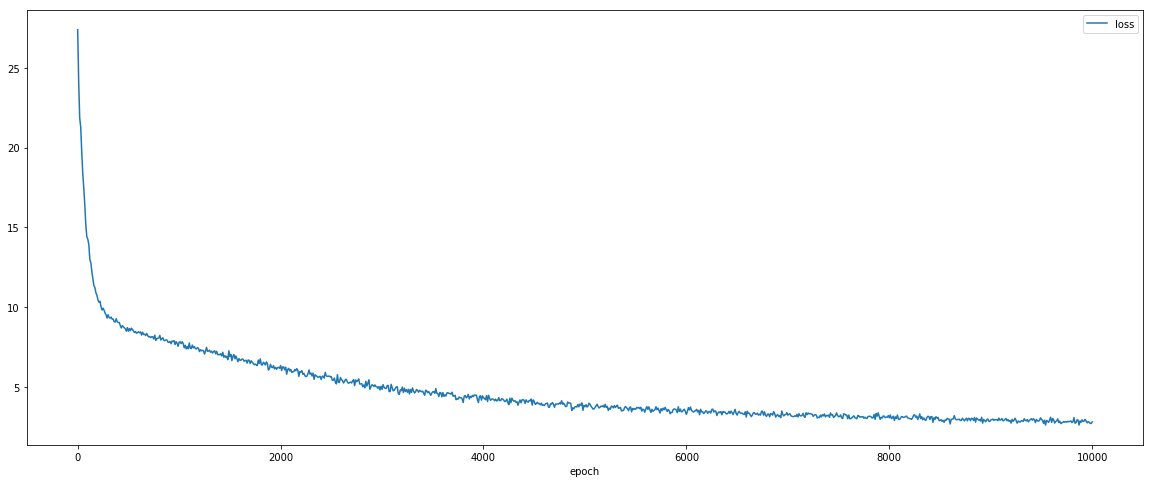

In [31]:
points.plot.line(x='epoch', y='loss',figsize=(20,8))